In [8]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sounddevice as sd

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
import mdctn
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

In [7]:
!pip install mdctn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Useful functions

In [9]:
def load_sound(file):
    return wave.open(file, 'rb')

def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [10]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [11]:
wavefile = load_sound('clocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [12]:
play = True
if play :
    play_sound('clocheB.WAV')

In [13]:
T, data, nframes, nchannels, sampling_frequency = read_values('clocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

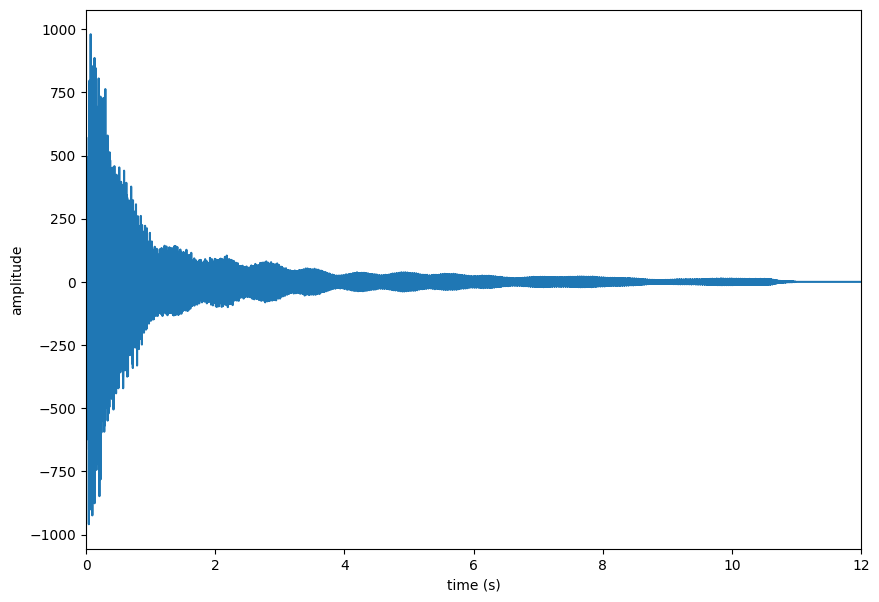

In [14]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [15]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

# 3 Signal synthétique

In [105]:
N = 63
f0 = 1/4
f1 = f0 + 1/N
f = np.array([f0, f1])
a = np.array([1, 10])
delta = np.array([0, -0.05])
phi = np.array([0, 0])

x = Synthesis(N, delta, f, a, phi)


## 3.1 Analyse spectrale par transformation de Fourier

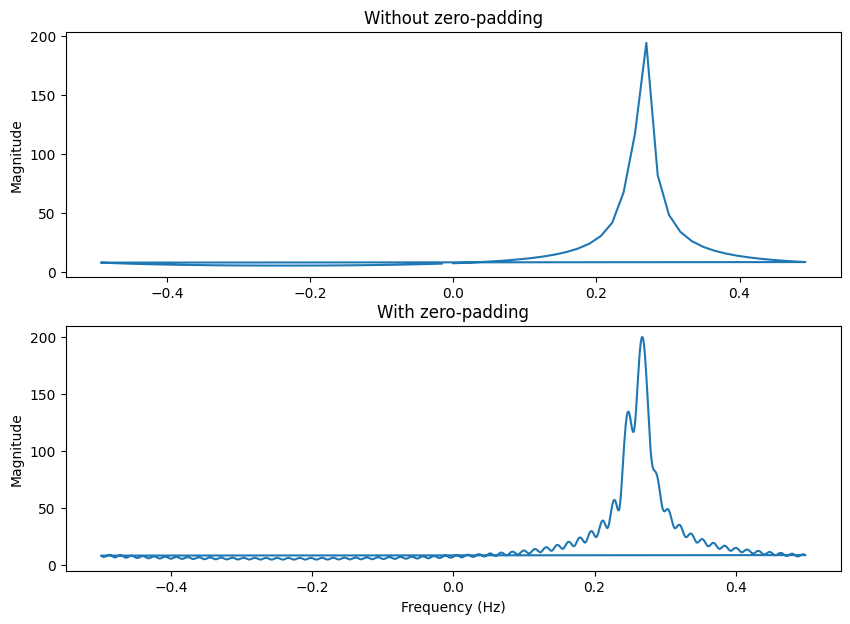

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

# without zero-padding

N_fft = N

X_fft = np.fft.fft(x, n=N_fft)
freqs = np.fft.fftfreq(N_fft)

ax[0].plot(freqs, np.abs(X_fft))
ax[0].set_ylabel('Magnitude')
ax[0].set_title('Without zero-padding')

# with zero-padding

N_fft = 1024 # >N

X_fft = np.fft.fft(x, n=N_fft)
freqs = np.fft.fftfreq(N_fft)

ax[1].plot(freqs, np.abs(X_fft))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')
ax[1].set_title('With zero-padding')

plt.show()


## 3.2 Méthodes à haute résolution

In [44]:
n = 32
K=2

1. Calcul de la matrice de corrélation

In [45]:
# get hankel matrix of x: X
def get_hankel(x, n):
    X = hankel(x[:n], x[n-1:])
    return X

# get correlation of X: R_xx
def get_correlation(X, n):
    l = x.shape[0] - n + 1
    R_xx = X @ X.transpose().conj() / l
    return R_xx

2. Estimation de l’espace signal

In [46]:
# get signal space W and Wt
def get_W(R_xx, K):
    U, _, Vh = np.linalg.svd(R_xx)
    W = U[:, :K]
    Wt = Vh[:, K:]
    return W, Wt


### 3.2.1 Algorithme ESPRIT

3. Estimation des fréquences et des facteurs d’amortissement

In [ ]:
def get_delta_f(W):
    # get W_up and W_down from W
    W_up = W[1:, :]
    W_down = W[:-1, :]

    # compute Phi
    Phi = np.linalg.pinv(W_down) @ W_up

    # get eigenvalues of Phi
    zk,_ = np.linalg.eig(Phi)

    delta_k = np.log(np.abs(zk))
    f_k = np.angle(zk) / (2 * np.pi)

    return delta_k, f_k

def ESPRIT(x, n, K):
    X = get_hankel(x, n)
    R_xx = get_correlation(X, n)
    W, Wt = get_W(R_xx, K)
    delta_k, f_k = get_delta_f(W)
    return delta_k, f_k

4. Estimation des amplitudes et des phases

In [53]:
def LeastSquares(x, delta, f):
    ln_z = delta + 2j * np.pi * f
    V = np.exp(np.outer(np.arange(x.shape[0]), ln_z))
    alpha = np.linalg.pinv(V) @ x.transpose()
    a = np.abs(alpha)
    phi = np.angle(alpha)
    return a, phi

5. Application aux signaux synthétiques

In [55]:
delta, f = ESPRIT(x, n, K)
est_a, est_phi = LeastSquares(x, delta, f)

print(f'true a: {a}\t estimated a: {est_a}')
print(f'true phi: {phi}\t estimated phi: {est_phi}')

true a: [ 1 10]	 estimated a: [10.  1.]
true phi: [0 0]	 estimated phi: [1.41969769e-15 2.83280344e-15]


### 3.2.2 Méthode MUSIC

6. Affichage du pseudo-spectre MUSIC

In [104]:
def MUSIC(x, n, K, delta, f):
    X = get_hankel(x, n)
    R_xx = get_correlation(X, n)
    _, Wt = get_W(R_xx, K)
    
    z = np.exp(delta + 2j * np.pi * f)
    # v = [1, z, z^2, ..., z^(n-1)]
    v = np.array([z**k for k in range(n)])
    P = 1 / np.linalg.norm(Wt.transpose().conj() @ v) ** 2

    return P

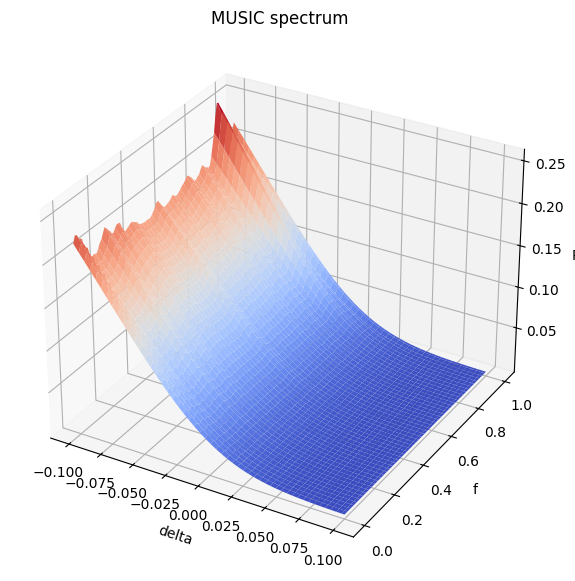

In [111]:
delta_vals = np.linspace(-0.1, 0.1, 100)
f_vals = np.linspace(0, 1, 100)
delta_grid, f_grid = np.meshgrid(delta_vals, f_vals)

P = np.zeros((len(f_vals), len(delta_vals)))
for i, f in enumerate(f_vals):
    for j, delta in enumerate(delta_vals):
        P[i, j] = MUSIC(x, n, K, delta, f)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(delta_grid, f_grid, P, cmap=cm.coolwarm)
ax.set_xlabel('delta')
ax.set_ylabel('f')
ax.set_zlabel('P')
ax.set_title('MUSIC spectrum')
plt.show()
